In [ ]:
!pip install transformers
!pip install datasets

In [ ]:
import numpy as np
import pandas as pd

import torch

import json
import sys
import time
import datetime
import random
import collections
from pathlib import Path

import transformers
import datasets
from datasets import load_dataset

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [ ]:
fix_random(seed=42)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class LoadData():
    def __init__(self,
                 path_to_json_file: str,
                 checkpoint_path: str,
                 train_file: str = 'train.json',
                 val_file: str = 'val.json') -> None:
        """Load the data by flattening the json file and saving it.

        Args:
            path_to_json_file: path to the json file.
            checkpoint_path: path where to save the json files.
            train_file: name of the train json file that will be created.
            val_file: name of the val json file that will be created.
        """

        self.path_to_json_file = path_to_json_file
        self.checkpoint_path = checkpoint_path

        self.train_file = train_file
        self.val_file = val_file

        self.data = self.load_data()

    def load_data(self):
        with open(self.path_to_json_file, 'r') as f:
            train_data = json.load(f)
        print(f'Flattening SQUAD {train_data["version"]}')
        train_data_flat, val_data_flat, errors = self.load_squad_data(train_data)
        print(f'\nErroneous Datapoints: {errors}')

        with open(Path(self.checkpoint_path) / Path(self.train_file), 'w') as file:
            train_data = {'data':train_data_flat}
            file.write(json.dumps(train_data))
            file.close()

        with open(Path(self.checkpoint_path) / Path(self.val_file), 'w') as file:
            val_data = {'data':val_data_flat}
            file.write(json.dumps(val_data))
            file.close()

    def load_squad_data(self, data, split=0.2):

        errors = 0
        flattened_data_train = []
        flattened_data_val = []

        train_range = len(data['data']) - (len(data['data']) * split)

        for i, article in enumerate(data["data"]):
            title = article.get("title", "").strip()
            for paragraph in article["paragraphs"]:
                context = paragraph["context"].strip()
                for qa in paragraph["qas"]:
                    question = qa["question"].strip()
                    id_ = qa["id"]

                    answer_starts = [answer["answer_start"] for answer in qa["answers"]]
                    answers = [answer["text"].strip() for answer in qa["answers"]]

                    # Features currently used are "context", "question", and "answers".
                    # Others are extracted here for the ease of future expansions.
                    if i <= train_range:
                        flattened_data_train.append({"title": title,
                                                     "context": context,
                                                     "question": question,
                                                     "id": id_,
                                                     "answers": {
                                                         "answer_start": answer_starts,
                                                         "text": answers}
                                                     })
                    else:
                        flattened_data_val.append({"title": title,
                                                   "context": context,
                                                   "question": question,
                                                   "id": id_,
                                                   "answers": {
                                                       "answer_start": answer_starts,
                                                       "text": answers}
                                                   })

        return flattened_data_train, flattened_data_val, errors

In [ ]:
from datasets import load_dataset
train_data = load_dataset('json', data_files=data_path+"train.json", field='data')
val_data = load_dataset('json', data_files=data_path+"val.json", field='data')

Using custom data configuration default-8f4de82f4daa2955


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-8f4de82f4daa2955/0.0.0/dc7ee63ec8b554c48ecc5a8a6fbe27af8071408c244e4347cf9222d6206d83a2. Subsequent calls will reuse this data.


Using custom data configuration default-9129e4e01f74642c


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-9129e4e01f74642c/0.0.0/dc7ee63ec8b554c48ecc5a8a6fbe27af8071408c244e4347cf9222d6206d83a2. Subsequent calls will reuse this data.


In [ ]:
def get_text(answer: list) -> str:
    """Extract only the text from the answers.text column

    Args:
        answer: the answer.
    """
    return answer[0]

def get_json_data(json_path: str) -> dict:
    """Get the json data in form of a dictionary

    Args:
        json_path: path to the json file.
    """
    # Opening JSON file
    f = open(json_path)
    # returns JSON object as a dictionary
    json_data = json.load(f)
    # Closing file
    f.close()
    return json_data

train_dataframe = pd.json_normalize(get_json_data(data_path+"train.json"), record_path='data')
train_dataframe["answers.text"] = train_dataframe["answers.text"].apply(get_text)


val_dataframe = pd.json_normalize(get_json_data(data_path+"val.json"), record_path='data')
val_dataframe["answers.text"] = val_dataframe["answers.text"].apply(get_text)

train_dataframe

,title,context,question,id,answers.answer_start,answers.text
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182,[515],Saint Bernadette Soubirous
1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,5733be284776f4190066117f,[188],a copper statue of Christ
2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180,[279],the Main Building
3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,5733be284776f41900661181,[381],a Marian place of prayer and reflection
4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,5733be284776f4190066117e,[92],a golden statue of the Virgin Mary
...,...,...,...,...,...,...
69387,Empiricism,John Dewey (1859–1952) modified James' pragmat...,Who came up with 'instrumentalism'?,572b459134ae481900dead71,[0],John Dewey
69388,Empiricism,John Dewey (1859–1952) modified James' pragmat...,What did Dewey think about reality?,572b459134ae481900dead72,[317],reality is determined by past experience
69389,Empiricism,John Dewey (1859–1952) modified James' pragmat...,When was Dewey born?,572b459134ae481900dead73,[12],1859
69390,Empiricism,John Dewey (1859–1952) modified James' pragmat...,When did Dewey die?,572b459134ae481900dead74,[17],1952


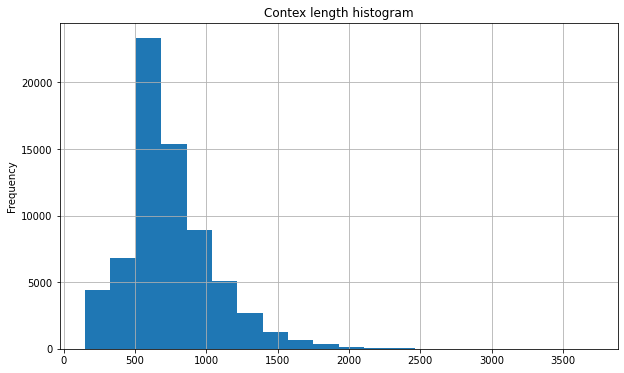

In [ ]:
figsize = (10,6)
train_dataframe['context'].apply(len).plot.hist(title="Contex length histogram", bins=20, figsize=figsize, grid=True)

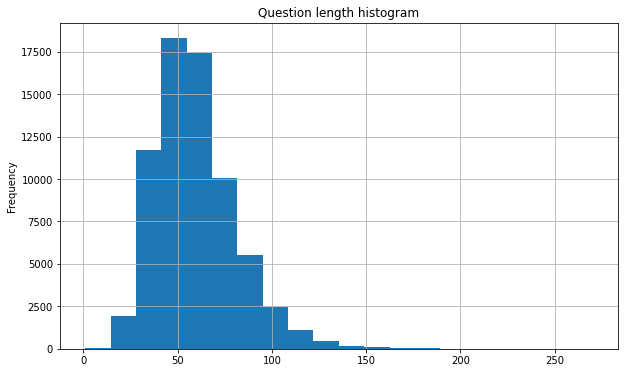

In [ ]:
train_dataframe['question'].apply(len).plot.hist(title="Question length histogram", bins=20, figsize=figsize, grid=True)

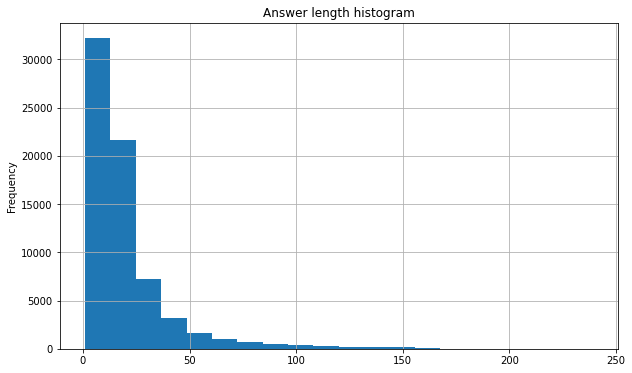

In [ ]:
train_dataframe['answers.text'].apply(len).plot.hist(title="Answer length histogram", bins=20, figsize=figsize, grid=True)

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [ ]:
tokenizer("What is your name?", "My name is Sylvain.")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 102, 2026, 2171, 2003, 25353, 22144, 2378, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

In [ ]:
def prepare_train_features(examples: collections.OrderedDict or dict) -> transformers.tokenization_utils_base.BatchEncoding:
    """Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
        in one example possible giving several features when a context is long, each of those features having a
        context that overlaps a bit the context of the previous feature.

      Args:
        examples: Squad samples
    """
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # CLS index
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        # Start/end character index of the answer in the text.
        start_char = answers["answer_start"][0]
        end_char = start_char + len(answers["text"][0])

        # Start token index of the current span in the text.
        token_start_index = 0
        while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
            token_start_index += 1

        # End token index of the current span in the text.
        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
            token_end_index -= 1

        # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
        if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
            # Note: we could go after the last offset if the answer is the last word (edge case).
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            tokenized_examples["start_positions"].append(token_start_index - 1)
            while offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [ ]:
features = prepare_train_features(train_data['train'][:5])

In [ ]:
train_tokenized_datasets = train_data.map(prepare_train_features, batched=True, remove_columns=train_data['train'].column_names)

In [ ]:
# DistilBert

import math

from transformers.modeling_outputs import QuestionAnsweringModelOutput
from transformers import DistilBertPreTrainedModel
from transformers import DistilBertModel

from torch import nn
from torch.nn import CrossEntropyLoss


def gelu(x):
    """
    Original Implementation of the GELU activation function in Google BERT repo when initially created. For
    information: OpenAI GPT's GELU is slightly different (and gives slightly different results): 0.5 * x * (1 +
    torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3)))) This is now written in C in
    torch.nn.functional Also see the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


def gelu_new(x):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415
    """
    return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))


class DistilBertForQuestionAnswering(DistilBertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.distilbert = DistilBertModel(config)

        self.qa_outputs_0 = nn.Linear(config.dim, 512)
        self.qa_outputs_1 = nn.Linear(512, 32)
        self.qa_outputs = nn.Linear(32, config.num_labels)

        assert config.num_labels == 2
        self.dropout = nn.Dropout(config.qa_dropout)

        self.LayerNorm = nn.LayerNorm(normalized_shape = [384,2])

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        start_positions=None,
        end_positions=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        start_positions (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for position (index) of the start of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (:obj:`sequence_length`). Position outside of the
            sequence are not taken into account for computing the loss.
        end_positions (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for position (index) of the end of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (:obj:`sequence_length`). Position outside of the
            sequence are not taken into account for computing the loss.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict


        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )


        hidden_states = distilbert_output[0]  # (bs, max_query_len, dim)
        hidden_states = self.dropout(hidden_states)  # (bs, max_query_len, dim)

        logits = gelu_new(self.qa_outputs_0(hidden_states))  # (bs, max_query_len, 2)
        logits = gelu_new(self.qa_outputs_1(logits))
        #logits = self.LayerNorm_0(logits)

        logits = self.qa_outputs(logits)
        logits = self.LayerNorm(logits)

        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1)  # (bs, max_query_len)
        end_logits = end_logits.squeeze(-1)  # (bs, max_query_len)


        total_loss = None
        if start_positions is not None and end_positions is not None:

            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            loss_fct = nn.CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2

        if not return_dict:
          output = (start_logits, end_logits) + distilbert_output[1:]
          return ((total_loss,) + output) if total_loss is not None else output

        return QuestionAnsweringModelOutput(
            loss=total_loss,
            start_logits=start_logits,
            end_logits=end_logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions
        )

In [ ]:
from transformers import TrainingArguments, Trainer

model = DistilBertForQuestionAnswering.from_pretrained(model_checkpoint)

# Tell pytorch to run this model on the GPU.
if torch.cuda.is_available():
  model.cuda()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs_0.weight', 'qa_outputs_0.bias', 'qa_outputs_1.weight', 'qa_outp

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The {} model has {:} different named parameters.\n'.format(model_checkpoint,len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layers ====\n')

for p in params[-10:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The distilbert-base-uncased model has 108 different named parameters.

==== Embedding Layer ====

distilbert.embeddings.word_embeddings.weight            (30522, 768)
distilbert.embeddings.position_embeddings.weight          (512, 768)
distilbert.embeddings.LayerNorm.weight                        (768,)
distilbert.embeddings.LayerNorm.bias                          (768,)
distilbert.transformer.layer.0.attention.q_lin.weight     (768, 768)

==== First Transformer ====

distilbert.transformer.layer.0.attention.q_lin.bias           (768,)
distilbert.transformer.layer.0.attention.k_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.k_lin.bias           (768,)
distilbert.transformer.layer.0.attention.v_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.v_lin.bias           (768,)
distilbert.transformer.layer.0.attention.out_lin.weight   (768, 768)
distilbert.transformer.layer.0.attention.out_lin.bias         (768,)
distilbert.transformer.layer.0.sa_layer_norm

In [ ]:
batch_size = 32
args = TrainingArguments(
    output_dir='./results',
    save_total_limit=5,
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    label_names=["start_positions", "end_positions"]
)

In [ ]:
from transformers import default_data_collator

data_collator = default_data_collator

In [ ]:
import collections
from tqdm import tqdm, tqdm_notebook


def postprocess_qa_predictions(examples: datasets.arrow_dataset.Dataset,
                               features: datasets.arrow_dataset.Dataset,
                               raw_predictions: tuple,
                               n_best_size: int = 20,
                               max_answer_length: int = 50) -> collections.OrderedDict:
    """Function used to select the best answer from the raw predictions

      Args:
        examples: Squad samples
        features: Squad features
        raw_predictions: model predictions
    """
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]
        valid_answers = []

        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

        # Let's pick our final answer
        predictions[example["id"]] = best_answer["text"]

    return predictions

In [ ]:
def prepare_validation_features(examples: collections.OrderedDict or dict) -> transformers.tokenization_utils_base.BatchEncoding:
    """To check a given span is inside the context (and not the question) and to get back the text inside.
        To do this, we need to add two things to our validation features:
        - the ID of the example that generated the feature (since each example can generate several features, as seen before);
        - the offset mapping that will give us a map from token indices to character positions in the context.
        That's why we will re-process the validation set with the following function, slightly different from `prepare_train_features`

      Args:
        examples: Squad samples
    """
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples["offset_mapping"]

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
      # CLS index
      input_ids = tokenized_examples["input_ids"][i]
      cls_index = input_ids.index(tokenizer.cls_token_id)

      # Grab the sequence corresponding to that example (to know what is the context and what is the question).
      sequence_ids = tokenized_examples.sequence_ids(i)

      # One example can give several spans, this is the index of the example containing this span of text.
      sample_index = sample_mapping[i]
      answers = examples["answers"][sample_index]

      # Start/end character index of the answer in the text.
      start_char = answers["answer_start"][0]
      end_char = start_char + len(answers["text"][0])

      # Start token index of the current span in the text.
      token_start_index = 0
      while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
          token_start_index += 1

      # End token index of the current span in the text.
      token_end_index = len(input_ids) - 1
      while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
          token_end_index -= 1

      # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
      if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
          tokenized_examples["start_positions"].append(cls_index)
          tokenized_examples["end_positions"].append(cls_index)
      else:
          # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
          # Note: we could go after the last offset if the answer is the last word (edge case).
          while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
              token_start_index += 1
          tokenized_examples["start_positions"].append(token_start_index - 1)
          while offsets[token_end_index][1] >= end_char:
              token_end_index -= 1
          tokenized_examples["end_positions"].append(token_end_index + 1)

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [ ]:
validation_features = val_data['train'].map(prepare_validation_features, batched=True, remove_columns=val_data['train'].column_names)

In [ ]:
metric = datasets.load_metric("squad")

In [ ]:
def compute_metrics(pred: transformers.trainer_utils.EvalPrediction) -> dict:
    # The Trainer hides the columns that are not used by the model (here example_id and offset_mapping which we will need for our post-processing), so we set them back
    validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

    # To get the final predictions we can apply our post-processing function to our raw predictions
    final_predictions = postprocess_qa_predictions(val_data['train'], validation_features, pred.predictions)

    # We just need to format predictions and labels a bit as metric expects a list of dictionaries and not one big dictionary
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
    references = [{"id": ex["id"], "answers": ex["answers"]} for ex in val_data["train"]]

    # Hide again the columns that are not used by the model
    validation_features.set_format(type=validation_features.format["type"], columns=['attention_mask', 'end_positions', 'input_ids', 'start_positions'])
    metrics = metric.compute(predictions=formatted_predictions, references=references)

    return metrics

In [ ]:
trainer = Trainer(
    model,
    args,
    compute_metrics=compute_metrics,
    train_dataset=train_tokenized_datasets["train"],
    eval_dataset=validation_features,
    data_collator=data_collator,
    tokenizer=tokenizer
)

In [ ]:
trainer.train()

In [ ]:
trainer.save_model(data_path + "test-squad-trained")